# 変分分類

このページでは、変分アルゴリズムを紹介し、変分量子[分類器](gloss:classifier)について説明および実装し、変分訓練について議論します。 

## 変分アルゴリズム

変分アルゴリズムは2014年に提唱され、参考文献1では変分[固有値ソルバー](gloss:eigensolver)、参考文献2では量子近似最適化アルゴリズムがあります。これらは[近い将来のアルゴリズム](gloss:near-term-algorithm)であり、現在の量子コンピューターと古典コンピューターが連携して実行できます。

パラメータ化された量子回路、またはansatz $U(\theta)$ を使用して、状態 $|\psi(\theta) \rangle = U(\theta) |0 \rangle$ を準備し、量子コンピューターを使って期待値を測定します。そして解決しようとしている問題に対して $\theta$ がどれだけ優れているかを決めるコスト関数 $C(\theta)$ を定義します。次に、古典コンピューターを使用してコスト関数を計算し、最適化アルゴリズムを使用して回路パラメータを更新します。アルゴリズムの目標は、コスト関数 $C(\theta)$ を最小化するパラメータ化された量子回路 $U(\theta)$ の回路パラメータ $\theta$ を見つけることです。

![](images/vqc/va.svg)

## 変分量子分類器

変分量子分類器は、測定された期待値が分類器の出力として解釈される変分アルゴリズムです。2018年に複数のグループによって導入されました。バイナリー分類問題の場合、入力データベクトル $\vec{x}_i$ とバイナリー出力ラベル $y_i= {0,1}$ として、入力データベクトルごとに、量子状態を出力するパラメーター化された量子回路を構築します。

$$ \cssId{_eq_1}{|\psi(\vec{x}_i;\vec{\theta}) \rangle =  U_{W(\vec{\theta})}U_{\phi(\vec{x}_i)}|0 \rangle}$$

ここで、 $U_{W(\vec{\theta})}$ は変分回路ユニタリーに対応し、 $U_{\phi(\vec{x}_i)}$ はデータエンコーディング回路ユニタリーに対応します。  $n$ 量子ビットの回路を作成して測定した後、 $n$ の長さのビット文字列が残り、そこから分類結果となるバイナリー出力を導出する必要があります。これは、ブール関数 $ \cssId{_map_1}{ f: \{0, 1\}^{n} \rightarrow \{0, 1\} }$ の助けを借りて行われます。[パリティ関数](gloss:parity-function)は、このための一般的な選択肢です。

![](images/vqc/vqc.svg)

訓練フェーズでは、最良の予測を提供する $\vec{\theta}$ の値を見つけようとします。古典コンピューターは、予測されたラベル $\hat{y_i}$ を提供されたラベル $y_i$ と比較し、コスト関数を使用して予測結果の成否を計算します。このコストに基づいて、古典コンピューターは、従来の最適化アルゴリズムを使用して、 $\vec{\theta}$ に別の値を選択します。次に、この新しい $\vec{\theta}$ を使用して新しい回路を実行し、コスト関数が安定するまでこの処理を繰り返します。

### 実装の全て

[Rodney Osodo](https://medium.com/qiskit/building-a-quantum-variational-classifier-using-real-world-data-809c59eb17c2) による [この実装](https://github.com/0x6f736f646f/variational-quantum-classifier-on-heartattack/blob/main/Src/Notebooks/02-qiskit.ipynb) に続いて、参考文献3で説明されているように、変分量子分類器のすべての個別のコンポーネントを実装し、  `adhoc` データセットを分類しましょう。

1. 各クラスから2つの機能の20のトレーニングデータポイントと5つのテストデータポイントを作成します。

In [1]:
from qiskit.utils import algorithm_globals
algorithm_globals.random_seed = 3142

import numpy as np
np.random.seed(algorithm_globals.random_seed)

from qiskit_machine_learning.datasets import ad_hoc_data
# pylint: disable=unbalanced-tuple-unpacking
TRAIN_DATA, TRAIN_LABELS, TEST_DATA, TEST_LABELS = (
    ad_hoc_data(training_size=20,
                test_size=5,
                n=2,
                gap=0.3,
                one_hot=False))
# pylint: enable=unbalanced-tuple-unpacking

2. 分類回路を準備します。参考文献3に示すように、データエンコーディング回路としてQiskitの`ZZFeatureMap`を使用し、変分回路として$Y$および$Z$回転と制御位相ゲートを持つQiskitの`TwoLocal`回路を使用します。

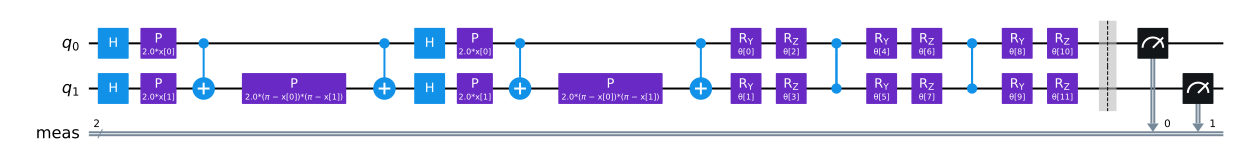

In [2]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal
FEATURE_MAP = ZZFeatureMap(feature_dimension=2, reps=2)
VAR_FORM = TwoLocal(2, ['ry', 'rz'], 'cz', reps=2)

AD_HOC_CIRCUIT = FEATURE_MAP.compose(VAR_FORM)
AD_HOC_CIRCUIT.measure_all()
AD_HOC_CIRCUIT.decompose().draw()

3. データを特徴マップに関連付け、変分パラメータを変分回路に関連付ける関数を作成します。これは、回路内の適切なパラメータが適切な量に関連付けられていることを確認するためです。

In [3]:
def circuit_instance(data, variational):
    """Assigns parameter values to `AD_HOC_CIRCUIT`.
    Args:
        data (list): Data values for the feature map
        variational (list): Parameter values for `VAR_FORM`
    Returns:
        QuantumCircuit: `AD_HOC_CIRCUIT` with parameters assigned
    """
    # pylint: disable=invalid-name
    parameters = {}
    for i, p in enumerate(FEATURE_MAP.ordered_parameters):
        parameters[p] = data[i]
    for i, p in enumerate(VAR_FORM.ordered_parameters):
        parameters[p] = variational[i]
    return AD_HOC_CIRCUIT.assign_parameters(parameters)

4. 与えられたビット列のパリティを計算するためのクラス割り当て関数を作成します。参考文献3のように、パリティが偶数の場合は$1$ラベルを返し、パリティが奇数の場合は$0$ラベルを返します。

In [4]:
def parity(bitstring):
    """Returns 1 if parity of `bitstring` is even, otherwise 0."""
    hamming_weight = sum(int(k) for k in list(bitstring))
    return (hamming_weight+1) % 2

5. 量子回路を複数回実行することによる実験的なカウントからラベルクラス全体の確率分布を返す関数を作成します。

In [5]:
def label_probability(results):
    """Converts a dict of bitstrings and their counts,
    to parities and their counts"""
    shots = sum(results.values())
    probabilities = {0: 0, 1: 0}
    for bitstring, counts in results.items():
        label = parity(bitstring)
        probabilities[label] += counts / shots
    return probabilities

6. データを分類する関数を作成します。データとパラメーターを取り込みます。データセット内のすべてのデータ点について、パラメーターを特徴マップに割り当て、パラメーターを変分回路に割り当てます。次に、系を展開して量子回路を保存し、最後に回路を一度に実行できるようにします。各回路を測定し、ビット列とクラスラベルに基づいて確率を返します。

In [6]:
from qiskit import BasicAer, execute

def classification_probability(data, variational):
    """Classify data points using given parameters.
    Args:
        data (list): Set of data points to classify
        variational (list): Parameters for `VAR_FORM`
    Returns:
        list[dict]: Probability of circuit classifying
                    each data point as 0 or 1.
    """
    circuits = [circuit_instance(d, variational) for d in data]
    backend = BasicAer.get_backend('qasm_simulator')
    results = execute(circuits, backend).result()
    classification = [
        label_probability(results.get_counts(c)) for c in circuits]
    return classification

7. 訓練では、損失関数とコスト関数を作成します。

In [7]:
def cross_entropy_loss(classification, expected):
    """Calculate accuracy of predictions using cross entropy loss.
    Args:
        classification (dict): Dict where keys are possible classes,
                               and values are the probability our
                               circuit chooses that class.
        expected (int): Correct classification of the data point.

    Returns:
        float: Cross entropy loss
    """
    # pylint: disable=invalid-name
    p = classification.get(expected)  # Prob. of correct classification
    return -np.log(p + 1e-10)

def cost_function(data, labels, variational):
    """Evaluates performance of our circuit with `variational`
    parameters on `data`.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): Parameters to use in circuit

    Returns:
        float: Cost (metric of performance)
    """
    # pylint: disable=invalid-name
    classifications = classification_probability(data, variational)
    cost = 0
    for i, classification in enumerate(classifications):
        cost += cross_entropy_loss(classification, labels[i])
    cost /= len(data)
    return cost

8. [`SPSA`](https://qiskit.org/documentation/stubs/qiskit.algorithms.optimizers.SPSA.html)を使用して（参考文献3のように）従来のオプティマイザーをセットアップし、再現性のために変分回路パラメーターを初期化し、40のトレーニングデータポイントを使用して変分回路パラメーターを変更するコスト関数を最適化します。最適化の実行には時間がかかることに注意してください。 

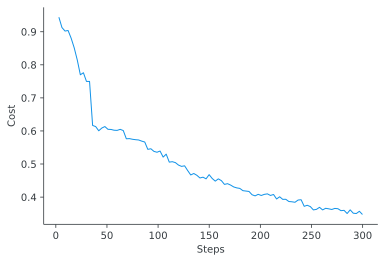

In [8]:
class OptimizerLog:  # pylint: disable=too-few-public-methods
    """Log to store optimizer's intermediate results"""
    def __init__(self):
        self.evaluations = []
        self.parameters = []
        self.costs = []
    def update(self, evaluation, parameter, cost, _stepsize, _accept):
        """Save intermediate results. Optimizer passes five values
        but we ignore the last two."""
        self.evaluations.append(evaluation)
        self.parameters.append(parameter)
        self.costs.append(cost)

# Set up the optimization
from qiskit.algorithms.optimizers import SPSA
log = OptimizerLog()
optimizer = SPSA(maxiter=100, callback=log.update)

#initial_point = np.random.random(VAR_FORM.num_parameters)
initial_point = np.array([3.28559355, 5.48514978, 5.13099949,
                          0.88372228, 4.08885928, 2.45568528,
                          4.92364593, 5.59032015, 3.66837805,
                          4.84632313, 3.60713748, 2.43546])

def objective_function(variational):
    """Cost function of circuit parameters on training data.
    The optimizer will attempt to minimize this."""
    return cost_function(TRAIN_DATA, TRAIN_LABELS, variational)

# Run the optimization
opt_var, opt_value, _ = optimizer.optimize(len(initial_point),
                                           objective_function,
                                           initial_point=initial_point)

import matplotlib.pyplot as plt
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

最適化ステップに関してコスト関数をプロットすると、最小値に収束し始めることがわかります。

9. 以前に作成した分類関数を使用して、変分量子分類器をスコアリングする関数を実装し、それを使用して、10個のテストデータポイントでトレーニング済み分類器をテストします。

In [9]:
def test_classifier(data, labels, variational):
    """Gets classifier's most likely predictions and accuracy of those
    predictions.

    Args:
        data (list): List of data points to classify
        labels (list): List of correct labels for each data point
        variational (list): List of parameter values for classifier

    Returns:
        float: Average accuracy of classifier over `data`
        list: Classifier's label predictions for each data point
    """
    probability = classification_probability(data, variational)
    predictions = [0 if p[0] >= p[1] else 1 for p in probability]
    accuracy = 0
    # pylint: disable=invalid-name
    for i, prediction in enumerate(predictions):
        if prediction == labels[i]:
            accuracy += 1
    accuracy /= len(labels)
    return accuracy, predictions

accuracy, predictions = test_classifier(TEST_DATA, TEST_LABELS, opt_var)
accuracy

0.7

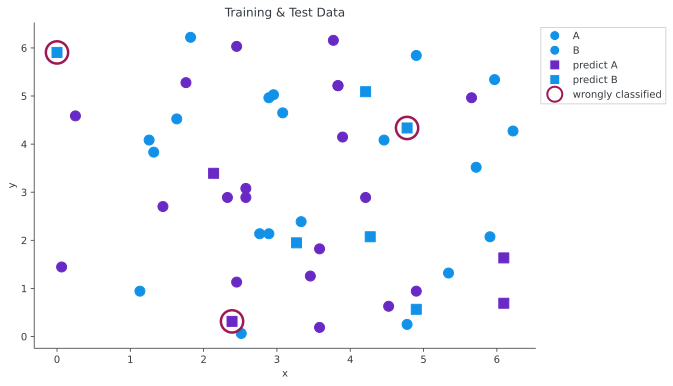

In [10]:
from matplotlib.lines import Line2D
plt.figure(figsize=(9, 6))

for feature, label in zip(TRAIN_DATA, TRAIN_LABELS):
    COLOR = 'C0' if label == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker='o', s=100, color=COLOR)

for feature, label, pred in zip(TEST_DATA, TEST_LABELS, predictions):
    COLOR = 'C0' if pred == 0 else 'C1'
    plt.scatter(feature[0], feature[1],
                marker='s', s=100, color=COLOR)
    if label != pred:  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='A', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict A',
           ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict B',
           ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
           label='wrongly classified', mew=2, ms=15)
]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
           loc='upper left')

plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

トレーニングされた分類器のパフォーマンスがテスト データで優れていないことがわかります。トレーニングの最適化では、トレーニングに時間がかかるか、[全体的な最小値](gloss:local-minimum)ではなく[局所的な最小値](gloss:global-minimum)が見つかった可能性があります。

### Qiskitでの実装

Qiskitには、 [`VQC`](https://qiskit.org/documentation/machine-learning/stubs/qiskit_machine_learning.algorithms.VQC.html)クラスの変分量子分類器の実装があります。同じデータセットで使用してみましょう。

まず、アルゴリズムの要件に応じてラベルを1つのホットエンコードする必要があります。

In [11]:
from sklearn.preprocessing import OneHotEncoder
encoder = OneHotEncoder()
train_labels_oh = encoder.fit_transform(TRAIN_LABELS.reshape(-1, 1)
                                       ).toarray()
test_labels_oh = encoder.fit_transform(TEST_LABELS.reshape(-1, 1)
                                      ).toarray()

次に、再現性のために初期変分回路パラメータを設定して`VQC`アルゴリズムを設定して実行します。その後先ほど作成した結果をプロットするコールバック関数を使用して結果をプロットします。

In [12]:
#initial_point = np.random.random(VAR_FORM.num_parameters)
initial_point = np.array([0.3200227 , 0.6503638 , 0.55995053,
                          0.96566328, 0.38243769, 0.90403094,
                          0.82271449, 0.26810137, 0.61076489,
                          0.82301609, 0.11789148, 0.29667125])

from qiskit_machine_learning.algorithms.classifiers import VQC
log = OptimizerLog()
vqc = VQC(feature_map=FEATURE_MAP,
          ansatz=VAR_FORM,
          loss='cross_entropy',
          optimizer=SPSA(callback=log.update),
          initial_point=initial_point,
          quantum_instance=BasicAer.get_backend('qasm_simulator'))

vqc.fit(TRAIN_DATA, train_labels_oh)

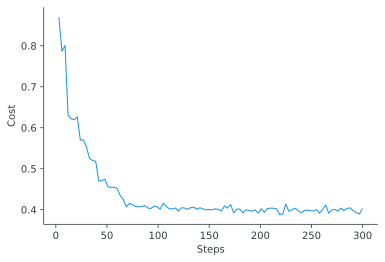

In [13]:
fig = plt.figure()
plt.plot(log.evaluations, log.costs)
plt.xlabel('Steps')
plt.ylabel('Cost')
plt.show()

第三に、訓練された分類器をテストデータでテストします。

In [14]:
# score == accuracy
vqc.score(TEST_DATA, test_labels_oh)

0.9

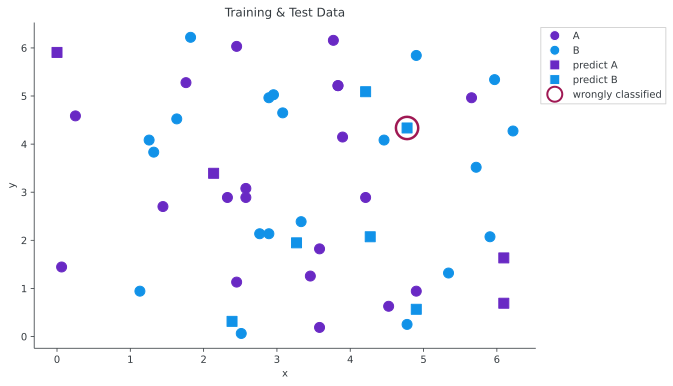

In [15]:
from matplotlib.lines import Line2D
plt.figure(figsize=(9, 6))

for feature, label in zip(TRAIN_DATA, train_labels_oh):
    COLOR = 'C1' if label[0] == 0 else 'C0'
    plt.scatter(feature[0], feature[1], marker='o', s=100,
                color=COLOR)

for feature, label, pred in zip(TEST_DATA, test_labels_oh,
                                vqc.predict(TEST_DATA)):
    COLOR = 'C1' if pred[0] == 0 else 'C0'
    plt.scatter(feature[0], feature[1], marker='s', s=100, color=COLOR)
    if not np.array_equal(label,pred):  # mark wrongly classified
        plt.scatter(feature[0], feature[1], marker='o', s=500,
                    linewidths=2.5, facecolor='none', edgecolor='C3')

legend_elements = [
    Line2D([0], [0], marker='o', c='w', mfc='C1', label='A', ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='C0', label='B', ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C1', label='predict A',
           ms=10),
    Line2D([0], [0], marker='s', c='w', mfc='C0', label='predict B',
           ms=10),
    Line2D([0], [0], marker='o', c='w', mfc='none', mec='C3',
           label='wrongly classified', mew=2, ms=15)
]

plt.legend(handles=legend_elements, bbox_to_anchor=(1, 1),
           loc='upper left')

plt.title('Training & Test Data')
plt.xlabel('x')
plt.ylabel('y')
plt.show()

訓練された分類器のパフォーマンスは、テストデータでかなり良好であることがわかります。トレーニングの最適化により、おそらく大域的最適解が見つかりました。

## 変分訓練

すべての変分アルゴリズムに言えますが、変分回路の最適なパラメータの探索に処理時間の大部分がかかり、[訓練のページ](./training-quantum-circuits)で説明されているように、採用する最適化手法に依存します。

![](images/vqc/va.svg)

損失関数の最小値 $f(\vec{\theta})$ が見つかると、最適な回路パラメーター $\vec{\theta}^*$ が見つかります。ただし、損失関数と回路パラメータの間には単純な関係はありません。

実際、以下の例の丘と谷に示されているように、損失の状況は非常に複雑になる可能性があります。最適化手法は、黒い点と線で示されているように、最小値を探して、損失の状況をナビゲートします。 3つの検索のうち2つは、グローバルなものではなく、ローカルのランドスケープの最小値になります。

![](images/vqc/loss-landscape.png)

一般に、最適化手法は、勾配ベースの手法と勾配情報を使わない手法の2つのグループに分類できます。最適解を決定するために、勾配ベースの方法は勾配がゼロに等しい極値点を識別します。探索方向が選択され、探索方向は損失関数の導関数によって決定されます。このタイプの最適化の主な欠点は、収束速度が非常に遅くなる可能性があり、最適解を見つける保証がないことです。

微分情報が利用できない、または取得が現実的でない場合(たとえば、損失関数の評価にコストがかかる場合や多少ノイズが多い場合)、勾配情報を使わない方法が非常に役立ちます。このような最適化手法は、大域的最適解の探索に対し堅牢な一方で、勾配ベースの方法は局所的最適解に収束する傾向があります。ただし、勾配情報を使わない方法では、特に高次元の探索空間の問題に対して、より高い計算能力が必要になります。

![](images/vqc/barren-plateaus.png)

どのタイプの最適化方法が使用されているかにかかわらず、損失ランドスケープがかなりフラットである場合、メソッドが検索する方向を決定するのは難しい場合があります。この状況は _[不毛の台地](gloss:barren-plateaus)_ と呼ばれ、参考文献4で研究されました。パラメータ化された量子回路の広いクラスにおいて、任意の合理的な方向に沿った勾配がある一定の精度で非ゼロになる確率は、量子ビットの数の関数として指数関数的に小さくなります。

この問題を克服するための1つのアプローチは、量子シミュレーションで採用されているような構造化された初期推定を使用することです。別の可能性は、完全な量子回路を一連の浅いブロックと見なし、いくつかのパラメータをランダムに選択し、残りのパラメーターを選択して、すべての浅い同一の回路のブロックが実効的な回路の深さを制限することです。これは現在研究中の領域です。

## 参考文献

1. Alberto Peruzzo, Jarrod McClean, Peter Shadbolt, Man-Hong Yung, Xiao-Qi Zhou, Peter J. Love, Alán Aspuru-Guzik and Jeremy L. O'Brien, *A variational eigenvalue solver on a quantum processor*, Nature Communications, 5:4213 (2014), [doi.org:10.1038/ncomms5213](https://doi.org/10.1038/ncomms5213), [arXiv:1304.3061](https://arxiv.org/abs/1304.3061).
2. Edward Farhi, Jeffrey Goldstone and Sam Gutmann, *A Quantum Approximate Optimization Algorithm* (2014), [arXiv:1411.4028](https://arxiv.org/abs/1411.4028).
3. Vojtech Havlicek, Antonio D. Córcoles, Kristan Temme, Aram W. Harrow, Abhinav  Kandala, Jerry M. Chow and Jay M. Gambetta, *Supervised learning with quantum enhanced feature spaces*, Nature 567, 209-212 (2019), [doi.org:10.1038/s41586-019-0980-2](https://doi.org/10.1038/s41586-019-0980-2), [arXiv:1804.11326](https://arxiv.org/abs/1804.11326).
4. Jarrod R. McClean, Sergio Boixo, Vadim N. Smelyanskiy, Ryan Babbush and Hartmut Neven, *Barren plateaus in quantum neural network training landscapes*, Nature Communications volume 9, Article number: 4812 (2018), [doi.org:10.1038/s41467-018-07090-4](https://www.nature.com/articles/s41467-018-07090-4) [arXiv:1803.1117](https://arxiv.org/abs/1803.11173)

In [16]:
# pylint: disable=unused-import
import qiskit.tools.jupyter
%qiskit_version_table

Qiskit Software,Version
qiskit-terra,0.20.0
qiskit-aer,0.10.4
qiskit-ignis,0.7.0
qiskit-ibmq-provider,0.19.0
qiskit-aqua,0.9.5
qiskit,0.36.0
qiskit-nature,0.4.1
qiskit-finance,0.3.2
qiskit-optimization,0.3.2
qiskit-machine-learning,0.4.0
